# Airbnb Data

In this setion, we will use the same Airbnb dataset that we used in homework. We get our data from this source: https://www.kaggle.com/c/airbnblala/data#

In [1]:
using Random
Random.seed!(13)

using CSV, Plots, DataFrames, Statistics, DelimitedFiles, LinearAlgebra

In [2]:
df = CSV.read("airbnb.csv")

feature_names = names(df)
for i in 1:96
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	id			Int64
2	listing_url			String
3	scrape_id			Int64
4	last_scraped			Dates.Date
5	name			Union{Missing, String}
6	summary			Union{Missing, String}
7	space			Union{Missing, String}
8	description			Union{Missing, String}
9	experiences_offered			String
10	neighborhood_overview			Union{Missing, String}
11	notes			Union{Missing, String}
12	transit			Union{Missing, String}
13	access			Union{Missing, String}
14	interaction			Union{Missing, String}
15	house_rules			Union{Missing, String}
16	thumbnail_url			String
17	medium_url			String
18	picture_url			String
19	xl_picture_url			String
20	host_id			Int64
21	host_url			String
22	host_name			String
23	host_since			Dates.Date
24	host_location			Union{Missing, String}
25	host_about			Union{Missing, String}
26	host_response_time			String
27	host_response_rate			String
28	host_acceptance_rate			String
29	host_is_superhost			String
30	host_thumbnail_url			String
31	host_picture_url			String
32	host_neighbourhood			Union{Missing, String}
33	host_l

Train / Test Split

We're going to say that the price columns, 61, 62, and 63, are not independent variables, while everything else is. We now will generate a "data" collection, a "target" collection (column 61), and create a train/test split so that we can empirically test for overfitting.

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first $80\%$ as the train data, with $20\%$ held out for validation.

Use the code below to create a train / test split.

In [3]:
df = df[.!(ismissing.(df[!, :price])), :]; # let's only consider the examples for which the price is known
df = df[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))
# The first t examples will form our training set; the rest will be our test set
t = convert(Int, round(train_proportion*n))

target = df[:, :price]
data = df[:, filter(col -> (col != :price && col!= :weekly_price && col!= :monthly_price), feature_names)]

train_x = data[1:t, :]
test_x = data[t:end, :]
train_y = target[1:t, :]
test_y = target[t:end, :]

Size of dataset: 25951


5191×1 Array{Int64,2}:
 197
 200
 175
  85
 135
  65
  83
  40
 105
 150
 210
 200
  50
   ⋮
  45
 200
 200
 150
 225
 145
  50
  80
  65
  39
  95
  52

In [4]:
# This function just computes the mean squared error.
function MSE(y, pred)
    sum((y - pred).^2)/size(y, 1)
end

"""This function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end


"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", zeromin=true)
end

plot_pred_true

## Text

The following columns consist of long-form textual descriptions:

  - name
  - summary
  - space
  - neighborhood_overview
  - notes
  - transit
  - access
  - interaction
  - house_rules

We will experiment with using features from a pretrained neural network to represent this data.
The neural network has learned an internal representation (say, at some hidden layer of the network) that it uses to make its predictions on a different task (such as sentiment prediction for sentences). 

We will use this internal representation directly for our task of AirBnB price prediction.
Using an internal representation from an unrelated model as a feature is a common technique known as transfer learning.

We will use pretrained features from the Universal Sentence Encoder (USE), which was designed explicitly for transfer learning to different tasks. 
[This paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46808.pdf) documents how this neural network architecture was designed and trained: 
This network consumes text of arbitrary length, and produces a feature vector of length $512$. 

Your TAs have precomputed these features for all of the columns above into the table "airbnb-use-embeddings.csv",
available [as a zip file on the course website](https://people.orie.cornell.edu/mru8/orie4741/homework/airbnb-use-embeddings.zip).
The id of each AirBnB listing is provided, along with features with names of the form "column_number:feature_number". That is, the 468th feature of the 5th text data column (also known as the "name" column) will be found at '5:468'.

You can use [this demo code](https://tfhub.dev/google/universal-sentence-encoder/2)) to explore the USE embedding further. If you would like to use this (or any other) embedding for your project, you are welcome to come to Office Hours and we will gladly help you with your project.

Returning to the AirBnB dataset, we can import the data into a new dataframe. Since our training data has been shuffled, we use a dataset join to assemble the data below.

In [5]:
df_tf = CSV.read("airbnb-use-embeddings.csv")

train_all = join(train_x, df_tf, on=:id, kind=:left);
test_all = join(test_x, df_tf, on=:id, kind=:left);

In [6]:
print(size(train_x))
train_embed = convert(Matrix, train_all[:, 94:end]);
test_embed = convert(Matrix, test_all[:, 94:end]);

(20761, 93)

First, like what we did in homework, we fit the linear regression (with offset) model using the entire dataset.

In [7]:
train_embed_only = hcat(train_embed, ones(size(train_embed, 1)))
test_embed_only = hcat(test_embed, ones(size(test_embed, 1)))

@time begin
w_em = train_embed_only\train_y
end
    
train_pred = train_embed_only*w_em
test_pred = test_embed_only*w_em

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", string(train_MSE))
println("Test MSE \t", string(test_MSE))

 84.840584 seconds (4.59 M allocations: 1.250 GiB, 0.31% gc time)
Train MSE	4937.336007660289
Test MSE 	8057.226414904806


In [8]:
size(train_embed_only)

(20761, 4609)

We can see that there is a large number of features. Since linear regression usually requires the number of data points to be much more than the number of features, we resort to PCA for dimensionality reduction.

In [9]:
U, S, V = svd(train_embed_only);

Plot decay of singular values

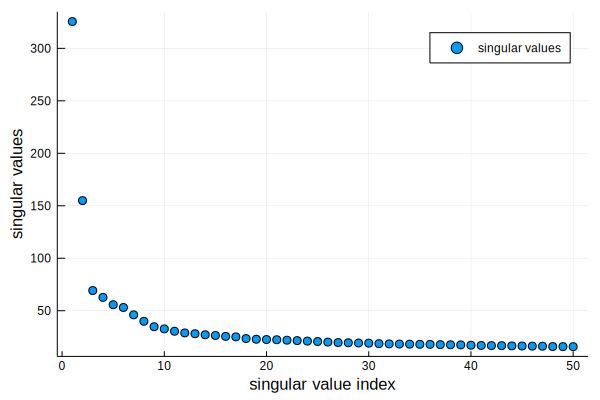

In [10]:
k_to_plot = 50

scatter(1:k_to_plot, S[1:k_to_plot], label="singular values")
xlabel!("singular value index")
ylabel!("singular values")

Plot explained variance (the sum of first several singular values over the sum of all singular values):

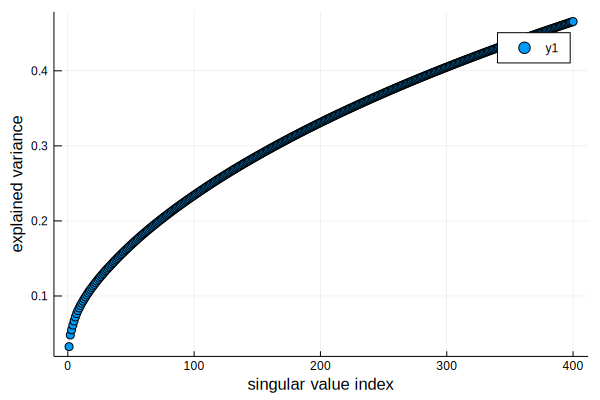

In [11]:
k_to_plot = 400

scatter(1:k_to_plot, [sum(S[1:i]) / sum(S) for i=1:k_to_plot])
xlabel!("singular value index")
ylabel!("explained variance")

We loop over rank k from 10 to 100 and take a look at how training and test errors change. The following block may take a really long time, thus you may run the code in two blocks after the following block to quickly load results from previous executions.

In [ ]:
train_MSE_pca_all = []
test_MSE_pca_all = []

println("Train MSE of full dataset \t", string(train_MSE))
println("Test MSE of full dataset \t", string(test_MSE))

for k in 10:10:200
    println(k)
    
    Uk = U[:, 1:k];
    Sk = S[1:k];
    Vk = V[:, 1:k];
    
    train_embed_pca =  train_embed_only * Vk
    test_embed_pca = test_embed_only * Vk

    w_em_pca = train_embed_pca \ train_y

    train_pred_pca = train_embed_pca * w_em_pca
    test_pred_pca = test_embed_pca * w_em_pca

    train_MSE_pca = MSE(train_y, train_pred_pca)
    test_MSE_pca = MSE(test_y, test_pred_pca)

    println("Train MSE\t", string(train_MSE_pca))
    println("Test MSE \t", string(test_MSE_pca))
    
    append!(train_MSE_pca_all, train_MSE_pca)
    append!(test_MSE_pca_all, test_MSE_pca)    
    
end

Save results:

In [ ]:
writedlm("train_MSE_pca_all.txt", train_MSE_pca_all)
writedlm("test_MSE_pca_all.txt", test_MSE_pca_all)

Read previously saved results from local:

In [12]:
train_MSE_pca_all = readdlm("train_MSE_pca_all.txt");
test_MSE_pca_all = readdlm("test_MSE_pca_all.txt");

Plot the training and test errors of fitting the linear regression model on both the entire dataset and the dimensionality reduced dataset:

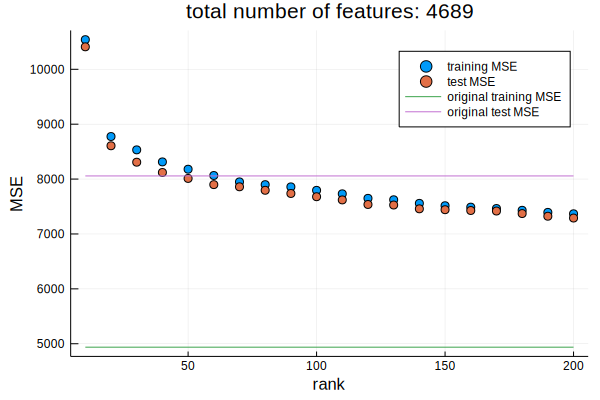

In [13]:
a = scatter(10:10:200, train_MSE_pca_all, label="training MSE")
b = scatter!(a, 10:10:200, test_MSE_pca_all, label="test MSE")
c = plot!(b, 10:200, [train_MSE for i=10:200], label="original training MSE")
d = plot!(c, 10:200, [test_MSE for i=10:200], label="original test MSE")
xlabel!("rank")
ylabel!("MSE")
title!("total number of features: 4689")

Note that this embedding provides a lot of information, but we are massively overfitting. This is to be expected: after all we have $4689$ parameters to fit, but only $20000$ training points. This makes PCA helpful for addressing overfitting.